In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
from PIL import Image, UnidentifiedImageError, ImageStat
import torch
from torch import nn
from torchvision import transforms
import hashlib
from ray import tune
from ray.tune import Tuner
from ray.tune.schedulers import ASHAScheduler
import time
import json
import numpy as np

from cancer_classifier.modeling.models.cnnmodel import CNNModel
from cancer_classifier.modeling.models.vit_ref_book import ViTModel
from cancer_classifier.modeling.models.vit_diff_head_cls import ViT_diff_head_cls_model
from cancer_classifier.modeling.models.vit_diff_head_no_cls import Vit_diff_head_no_cls_model
from cancer_classifier.modeling.models.vit_diff_head_mlp_over_rep import ViT_diff_head_mlp_over_rep
from cancer_classifier.modeling.train import train
from cancer_classifier.config import PROCESSED_DATA_DIR, RAW_DATA_DIR
from cancer_classifier.processing.data_loader import BrainTumorDataset
from cancer_classifier.plots import visualize_sample_images,  plot_confusion_matrix, plot_loss_curves


2025-05-21 00:36:21.642 | INFO     | cancer_classifier.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/deep-learning-cancer-classifier


# 1. Data Analysis

In [2]:
csv_path = os.path.join(RAW_DATA_DIR, 'dataset.csv')
labels = pd.read_csv(csv_path)
print(labels)

          label  number_of_files
0  brain_glioma             2004
1   brain_menin             2004
2   brain_tumor             2048


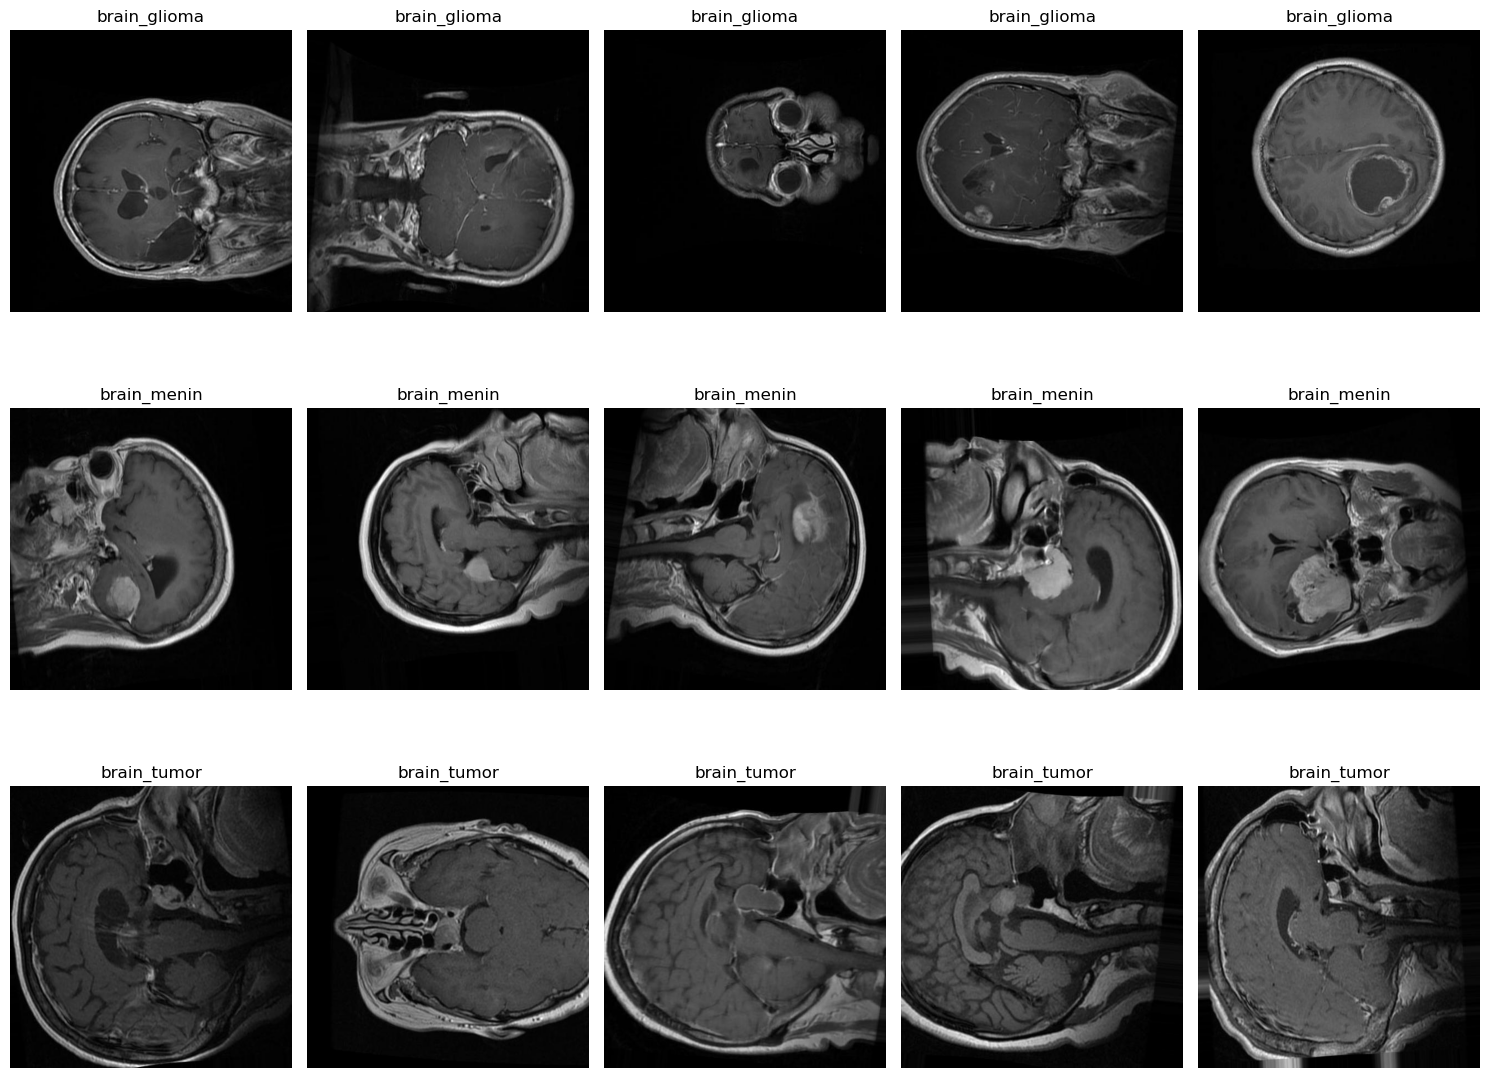

In [3]:
classes = labels['label'].tolist()
samples_per_class = 5

fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15, 4 * len(classes)))

for i, cls in enumerate(classes):
    class_path = os.path.join(RAW_DATA_DIR, cls)
    images = [img for img in os.listdir(class_path) if img.endswith('.jpg')]
    chosen = random.sample(images, samples_per_class)

    for j, img_name in enumerate(chosen):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path).convert('RGB')
        axes[i, j].imshow(img)
        axes[i, j].set_title(cls)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [4]:
image_dims = []

for cls in classes:
    cls_dir = os.path.join(RAW_DATA_DIR, cls)
    for img_file in os.listdir(cls_dir):
        if img_file.lower().endswith('.jpg'):
            img_path = os.path.join(cls_dir, img_file)
            with Image.open(img_path) as img:
                image_dims.append(img.size)

unique_sizes = set(image_dims)
if len(unique_sizes) == 1:
    print(f"All images have the same size: {unique_sizes.pop()}")
else:
    print(f"Multiple image sizes found: {unique_sizes}")

All images have the same size: (512, 512)


In [5]:
dataset = BrainTumorDataset(root_dir=RAW_DATA_DIR)
mean, std = dataset.get_mean_std()
print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.1541])
Std: tensor([0.1668])


In [6]:
corrupt_images = []

for path in dataset.image_paths:
    try:
        img = Image.open(path)
        img.verify()
    except (UnidentifiedImageError, OSError):
        corrupt_images.append(path)

print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [7]:
black_images = []

to_tensor = transforms.ToTensor()

for path in dataset.image_paths:
    img = to_tensor(Image.open(path).convert('RGB'))
    if torch.all(img == 0):
        black_images.append(path)

print(f"Found {len(black_images)} completely black images.")

Found 0 completely black images.


In [8]:
hashes = {}
duplicates = []

for path in dataset.image_paths:
    with open(path, 'rb') as f:
        filehash = hashlib.md5(f.read()).hexdigest()
    if filehash in hashes:
        duplicates.append((path, hashes[filehash]))
    else:
        hashes[filehash] = path

print(f"Found {len(duplicates)} duplicate image pairs.")

Found 0 duplicate image pairs.


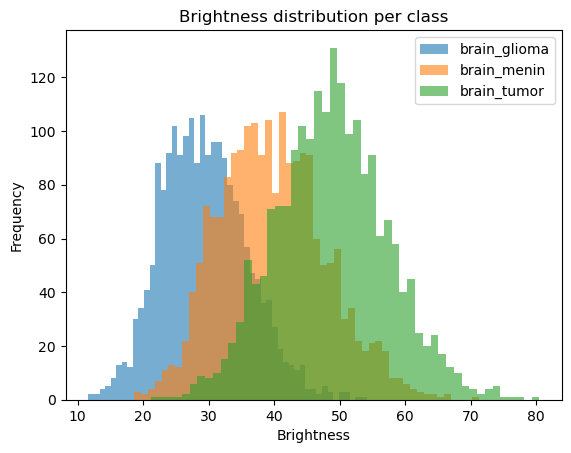

In [9]:
brightness = {cls: [] for cls in dataset.class_to_idx}

for path, label in zip(dataset.image_paths, dataset.labels):
    img = Image.open(path).convert('L')
    stat = ImageStat.Stat(img)
    brightness_value = stat.mean[0]
    for cls_name, idx in dataset.class_to_idx.items():
        if idx == label:
            brightness[cls_name].append(brightness_value)

for cls, values in brightness.items():
    plt.hist(values, bins=50, alpha=0.6, label=cls)

plt.legend()
plt.title("Brightness distribution per class")
plt.xlabel("Brightness")
plt.ylabel("Frequency")
plt.show()

# 2. Architecture

In [10]:
# Je ne sais pas quoi mettre ici, peut être expliquer briefement chaque modèle.

# 3. Training

In [11]:
dataset = BrainTumorDataset(root_dir=PROCESSED_DATA_DIR)
train_data, val_data, test_data = dataset.get_dataloaders(batch_size=32)

config = {
    "learning_rate": tune.grid_search([0.0001, 0.0005, 0.0012]),
    "optimizer": "adamw",
    "batch_size": 16,
    "img_size": 256,
    "model_name": "vit",
    "patch_size": 16,
    "num_hiddens": tune.grid_search([126, 516]),
    "num_heads": tune.grid_search([2, 8, 12]),
    "mlp_num_hiddens": 156,
    "num_blks": tune.grid_search([2, 6, 12]),
    "blk_dropout": 0.2,
    "emb_dropout": 0.2,
    "weights_decay": 0.0001,
    "epochs": 35,
    "data_path": os.path.abspath(PROCESSED_DATA_DIR),
    "loss_fn":nn.CrossEntropyLoss(),
    "use_bias": False,
    "fc_dropout_prob" : 0.3,
    "dropout_prob": 0.2,
    "num_classes": 3,
}

trainable_with_resources = tune.with_resources(
    tune.with_parameters(train, model_class=ViTModel, device="cuda", train_data=train_data, val_data=val_data, test_data=test_data, toTune=True),
    {"cpu": 2, "gpu": 1}
)

tuner = Tuner(
    trainable_with_resources,
    param_space=config,
    tune_config=tune.TuneConfig(
        #num_samples=4,
        metric="avg_val_acc",
        mode="max",
        scheduler=ASHAScheduler()
    ),
    run_config=tune.RunConfig(name="brain_tumor_ray_tuning"),
)

results = tuner.fit()

(pid=1301734) 2025-05-21 00:38:23.711 | INFO     | cancer_classifier.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/deep-learning-cancer-classifier
Training:   0%|          | 0/35 [00:00<?, ?it/s]
(pid=1301746) 2025-05-21 00:38:23.746 | INFO     | cancer_classifier.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/deep-learning-cancer-classifier [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
Training:  97%|█████████▋| 34/35 [06:40<00:11, 11.46s/it]
(pid=1302761) 2025-05-21 00:45:17.672 | INFO     | cancer_classifier.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/deep-learning-cancer-classifier
Training: 100%|██████████| 35/35 [06:50<00:00, 11.74s/it]
(pid=1302927) 2025-05-21 00:45:24.874 | INFO     | cancer_classifier.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/d

In [12]:
best_result = results.get_best_result(metric="avg_val_acc", mode="max")
best_config = best_result.config
print("Best hyperparameters for ViT Model from ref book:", best_config)

Best hyperparameters for ViT Model from ref book: {'learning_rate': 0.0001, 'optimizer': 'adamw', 'batch_size': 16, 'img_size': 256, 'model_name': 'vit', 'patch_size': 16, 'num_hiddens': 516, 'num_heads': 8, 'mlp_num_hiddens': 156, 'num_blks': 12, 'blk_dropout': 0.2, 'emb_dropout': 0.2, 'weights_decay': 0.0001, 'epochs': 35, 'data_path': '/home/ayoubvip/deep-learning-cancer-classifier/data/processed', 'loss_fn': CrossEntropyLoss(), 'use_bias': False, 'fc_dropout_prob': 0.3, 'dropout_prob': 0.2, 'num_classes': 3}


In [13]:
# training all the others models with the tuned hyperparameters

best_config['model_name'] = 'cnn'
results_cnn = train(best_config, model_class=CNNModel, device="cuda", train_data=train_data, val_data=val_data, test_data=test_data, toTune=False)

best_config['model_name'] = 'vit'
results_ViT_diff_head_cls_model = train(best_config, model_class=ViT_diff_head_cls_model, device="cuda", train_data=train_data, val_data=val_data, test_data=test_data, toTune=False)
results_Vit_diff_head_no_cls_model = train(best_config, model_class=Vit_diff_head_no_cls_model, device="cuda", train_data=train_data, val_data=val_data, test_data=test_data, toTune=False)
results_ViT_diff_head_mlp_over_rep = train(best_config, model_class=ViT_diff_head_mlp_over_rep, device="cuda", train_data=train_data, val_data=val_data, test_data=test_data, toTune=False)


Training: 100%|██████████| 35/35 [24:47<00:00, 42.50s/it]


In [20]:
def convert_to_serializable(obj):
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, tuple):
        return tuple(convert_to_serializable(item) for item in obj)
    elif isinstance(obj, (torch.Tensor, np.ndarray)):
        return obj.tolist()
    elif isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, (np.floating,)):
        return float(obj)
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, (str, float, int)):
        return obj
    else:
        return str(obj)

def save_results_to_json(results, filename):
    results_serializable = {k: convert_to_serializable(v) for k, v in results.items()}
    with open(filename, "w") as f:
        json.dump(results_serializable, f, indent=4)

save_results_to_json(results_cnn, "results_cnn.json")
save_results_to_json(results_ViT_diff_head_cls_model, "results_ViT_diff_head_cls_model.json")
save_results_to_json(results_Vit_diff_head_no_cls_model, "results_Vit_diff_head_no_cls_model.json")
save_results_to_json(results_ViT_diff_head_mlp_over_rep, "results_ViT_diff_head_mlp_over_rep.json")

results_ViT_diff_ref_book = best_result.__dict__.get("metrics", {})
save_results_to_json(results_ViT_diff_ref_book, "results_ViT_ref_book.json")

# Have to see if there's a difference between results_ViT_ref_book.json and the others.